In [1]:
# Imports 
import numpy as np 
import matplotlib.pyplot as plt
import keras
from keras import layers
import io 
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from keras.callbacks import ModelCheckpoint
from keras.models import load_model




2024-06-02 18:27:00.464766: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Download and load the dataset.
fpath = "/Users/christosmichalopoulos/Desktop/segm/sequences.npy"
dataset = np.load(fpath)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255


# Inspect the dataset.
print("Training Dataset Shapes: " + str(train_dataset.shape))
print("Validation Dataset Shapes: " + str(val_dataset.shape))


# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (891, 20, 64, 64, 1)
Validation Dataset Shapes: (99, 20, 64, 64, 1)
Training Dataset Shapes: (891, 19, 64, 64, 1), (891, 19, 64, 64, 1)
Validation Dataset Shapes: (99, 19, 64, 64, 1), (99, 19, 64, 64, 1)


Displaying frames for example 126.


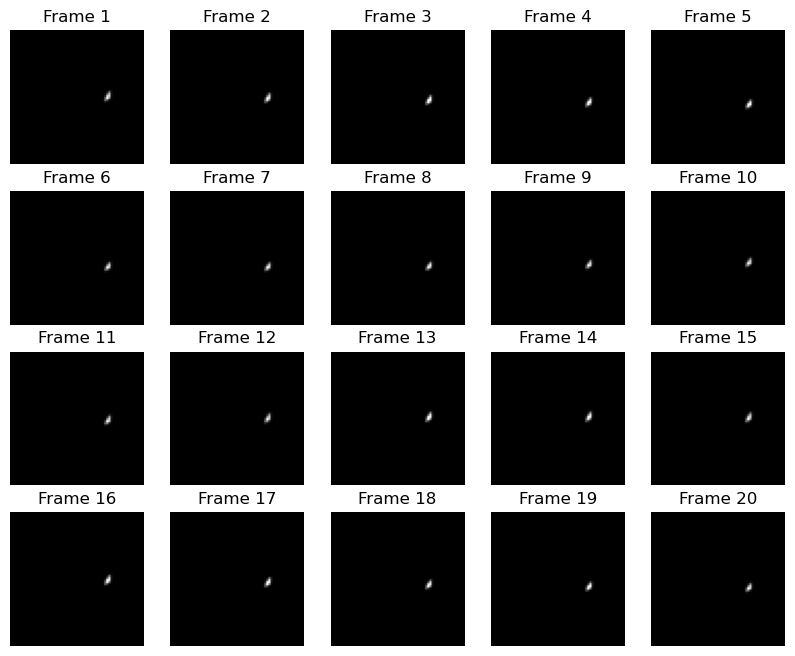

In [3]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [5]:
# ConvLSTM model 

inputs = layers.Input(shape=(None, *x_train.shape[2:]))

# First level of ConvLSTM
x = layers.ConvLSTM2D(filters = 64, kernel_size=(5,5), padding="same", return_sequences=True, activation = "relu")(inputs)
x = layers.BatchNormalization()(x)

# Second level of ConvLSTM
x = layers.ConvLSTM2D(filters = 64, kernel_size=(3,3), padding="same", return_sequences=True, activation = "relu")(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(filters = 64, kernel_size=(1,1), padding="same", return_sequences=True, activation = "relu")(x)

# Conv3D as we want spatiotemporal dimensions 
output = layers.Conv3D(filters=1, kernel_size=(3,3,3), activation="sigmoid", padding="same")(x)

conv_lstm = keras.models.Model(inputs, output)
loss = keras.losses()
optimizer = keras.optimizers.Adam()

conv_lstm.compile(loss = loss, optimizer = optimizer)
conv_lstm.summary()


TypeError: 'module' object is not callable